<h1><center>A Simple Classification Model</center></h1>   

This notebook demonstrate how to:
1. get useful features from the raw [Open University Learning Analytics dataset](https://analyse.kmi.open.ac.uk/open_dataset)
2. feed these features to a simple random forest model and do some analysis

In [1]:
import sys
import os
import pandas as pd
sys.path = [os.path.abspath('..')] + sys.path # have not install the university package yet
from university import data_loader, feature_pool, preprocessing, settings, features
from tqdm import tqdm_notebook

### 1. load data  

the `university.data_loader` module have two useful functions to load data:
1. `get_raw_data`: this will load the raw data
2. `train_test_split`: this will split the raw data into training/testing data

In [2]:
raw = data_loader.get_raw_data()

In [3]:
raw.keys()

dict_keys(['student_assessment', 'student_info', 'student_vle', 'courses', 'vle', 'student_registration', 'assessments'])

In [4]:
train, test = data_loader.train_test_split(raw)

### 2. data pipeline  

all the features are defined in `university.feature_pool` module.  These features can be categories to two main types: 
1. features that already exists in the raw data, but need proceessing (e.g., encode categorical data/ordinal data)
2. high level features that based on published work (e.g., time-regularities) and our current work (procrasitination and activity-regularity; these have not been fully implemented yet)

In [5]:
def build_features(data_source, targets=[['Pass', 'Distinction'], ['Fail']], start=0, end=32):
    r""" get X, y for training and testing
    Argument:
        data_source (dict): dictionary that contain the raw/train/test data
        targets (list of lists): targets that are of interest, see `university.feature_pool.get_response` doc for detail
        start (int): starting date of early prediction data snap shot 
        end (int): ending date of early prediction data snap shot
    Return:
        X, y as pd.DataFrame
    """
    
    # build y
    feature_container = feature_pool.get_response(data_source, targets)
    
    # buidld X
    num_features = feature_pool.get_numeric_features_batch(data_source)
    cat_features = feature_pool.get_categorical_features_batch(data_source)
    ord_features = feature_pool.get_ordinal_features_batch(data_source)
    regularity_features = feature_pool.get_time_regularity(data_source, start, end)
    effort_features = feature_pool.get_effort(data_source, start, end)
    
    # merge X and y to align the rows
    for sub_container in [num_features, cat_features, ord_features, regularity_features, effort_features]:
        feature_container.update(sub_container)
    
    data = feature_container.merge().data
    X = data[data.columns[1:]]
    y = data[data.columns[0:1]]
    
    return X, y

In [6]:
X_train, y_train = build_features(train)

In [7]:
X_test, y_test = build_features(test)

### 3. train a simple model

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer, precision_score, recall_score, confusion_matrix

In [9]:
f1_scorer = make_scorer(f1_score)
cv = KFold(5) # concerning the fitting speed, ideally this should be 20, at least

In [10]:
# random forest
forest = RandomForestClassifier(min_samples_split=10, min_samples_leaf=10, class_weight='balanced')
forest_parameters = {'n_estimators': (100, 200), 'max_depth': (10, 30)}
forest_clf = GridSearchCV(forest, forest_parameters, f1_scorer, cv=cv)

In [11]:
X_train.fillna(0, inplace=True) # adhoc, fill missing with zeros. Can do better.

In [25]:
forest_clf.fit(X_train.values, y_train.values.reshape(-1))

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=10,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                        

In [26]:
def evaluate(model, X_test, y_test):
    predict = model.predict(X_test)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    f1 = f1_score(y_test, predict)
    predict_ba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predict_ba)
    
    return precision, recall, f1, auc 

In [27]:
test_pre, test_rec, test_f1, test_auc = evaluate(forest_clf, X_test.fillna(0), y_test)

In [28]:
print('f1 score on training is {}'.format(forest_clf.best_score_))
print('f1 score on testing is {}'.format(test_f1))

f1 score on training is 0.5778100897607173
f1 score on testing is 0.5141430948419302


### 4. model analysis

###### 4.1 feature importance

In [29]:
# look at feature importance
feature_names = X_train.columns
feature_scores = forest_clf.best_estimator_.feature_importances_
feature_importance = pd.Series(feature_scores, index=feature_names)
feature_importance.sort_values(ascending=False).head(10)

regularity_indicator_ws1    0.166829
effort                      0.150347
regularity_indicator_ws3    0.119429
regularity_indicator_ws2    0.099892
regularity_indicator_pwd    0.086508
regularity_indicator_fwd    0.070243
highest_education           0.065237
imd_band                    0.050121
date_registration           0.046766
studied_credits             0.035705
dtype: float64

So, time regularity seems to be a very important indicator to check if students are going to fail/pass

###### 4.2 AUC

In [30]:
fpr, tpr, _ = roc_curve(y_test, forest_clf.predict_proba(X_test.fillna(0))[:, 1])

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

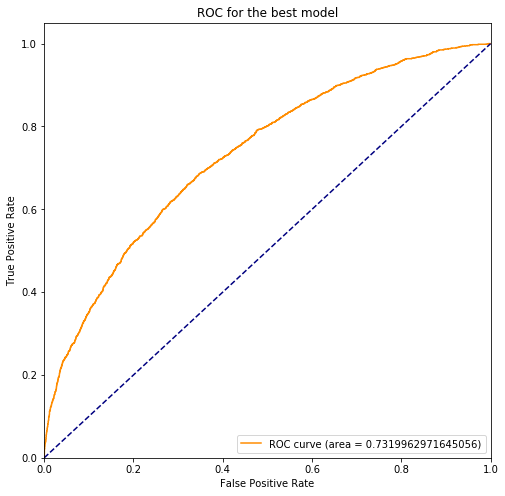

In [32]:
fig = plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = {})'.format(test_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for the best model')
plt.legend(loc="lower right")

###### 4.3 Confusion Matrix

In [33]:
y_pred = forest_clf.predict(X_test.fillna(0))

In [34]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['False', 'True'], columns=['Negative', 'Positive'])

,Negative,Positive
False,3862,1595
True,741,1236


###### 4.4 Optimal threshold

In [37]:
def best_threshold(y_true, proba, scoring='f1_score', step = 0.01):
    if scoring == 'f1_score':
        scoring_func = f1_score
    else:
        raise NotImplementedError
    
    # exclusively go through all
    thresholds = []
    scores = []
    threshold = 0
    
    while threshold <= 0.99:
        y_predict = (proba > threshold)
        curr_score = scoring_func(y_true, y_predict)
        
        thresholds.append(threshold)
        scores.append(curr_score)
        threshold += step
    return thresholds, scores

In [39]:
thresholds, scores = best_threshold(y_test, forest_clf.predict_proba(X_test.fillna(0))[:, 1])
best_score = max(scores)
index = scores.index(best_score)
best_threshold = thresholds[index]

/Users/banchisme/anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


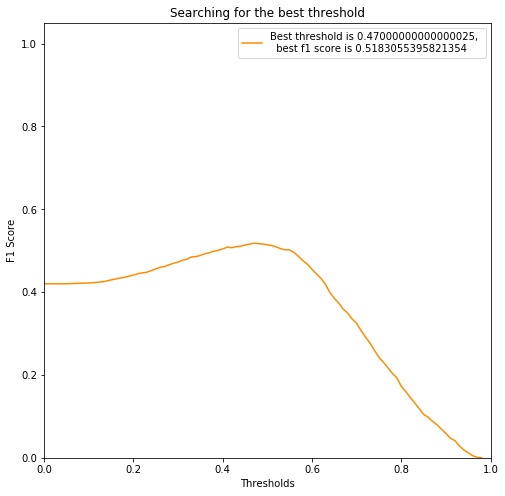

In [40]:
# visualize the threshold and scores
fig = plt.figure(figsize=(8, 8))
plt.plot(thresholds, scores, color='darkorange', 
         label='Best threshold is {}, \n  best f1 score is {}'.format(best_threshold, best_score))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('Searching for the best threshold')
plt.legend()